## Thực hiện việc mô phỏng tưới tiêu
Giả sử :
- model là chính xác 100%
- dự báo thời tiết là chính xác 100%

### Lấy giá trị dự báo thời tiết

In [1]:
import mysql.connector

mydb = mysql.connector.connect(
    host="sv-procon.uet.vnu.edu.vn",
    user="root",
    passwd="iotlab2018",
    database="irrigation_database"
)
print(mydb)
mycursor = mydb.cursor(buffered=True)
# mycursor.execute("select * from WeatherForecasts")
# myresult = mycursor.fetchall()

In [2]:
import datetime
datetime.time()
class status:
    def __init__(self,temperature,humidity):
        self.temperature=temperature
        self.humidity=humidity
    def __str__(self):
        return "temp: %f, hum: %f" % (self.temperature,self.humidity)
def formatTime(dt):
    return str(dt)
def nextHour(dt):
    return dt+datetime.timedelta(hours=1)
def getWeatherForecastAtATimeByTime(dt):
    mydb = mysql.connector.connect(
    host="sv-procon.uet.vnu.edu.vn",
    user="root",
    passwd="iotlab2018",
    database="irrigation_database")
    mycursor = mydb.cursor(buffered=True)
    mycursor.execute("select WeatherForecastID from WeatherForecasts where CurrentTime = '%s'" %str(dt))
    wfid = mycursor.fetchone()
#     print(wfid)
    mycursor.execute("select Temperature, RelativeHumidity from WeatherForecastAtATimes where WeatherForecastID=%d" %wfid)
    ret = []
    result = mycursor.fetchall()
#     print(result)
    for i in range(len(result)):
        temp = status(result[i][0],result[i][1])
#         print(temp)
        ret.append(temp)
    return ret
def getWeatherForecastAtATimeByString(s):
    mycursor.execute("select WeatherForecastID from WeatherForecasts where CurrentTime = '%s'" %s)
    wfid = mycursor.fetchone()
#     print(wfid)
    mycursor.execute("select Temperature, RelativeHumidity from WeatherForecastAtATimes where WeatherForecastID=%d" %wfid)
    ret = []
    result = mycursor.fetchall()
    print(result)
    for i in range(len(result)):
        temp = status(result[i][0],result[i][1])
#         print(temp)
        ret.append(temp)
    return ret
a = datetime.datetime.now()
formatTime(nextHour(a))

'2020-06-03 22:07:33.826395'

In [3]:
startTime = datetime.datetime(2020,5,3,13,0,0)
print(startTime)
a=getWeatherForecastAtATimeByString(formatTime(nextHour((startTime))))
a[0].temperature

2020-05-03 13:00:00
[(32.5, 63.0), (32.0, 63.0), (31.0, 67.0), (29.7, 75.0), (28.9, 81.0), (27.6, 87.0), (27.0, 88.0), (26.5, 86.0), (25.8, 91.0), (26.3, 89.0), (26.3, 89.0), (26.2, 90.0)]


32.5

### Khởi tạo 2 model cho việc nước tăng và nước giảm

#### Model tăng độ ẩm

In [4]:
class IncreaseModel:
    increaseDSoilMoisture = 1.2
    def getSoilMoisture(self,currentSM, periodTime):
        ret = currentSM+periodTime*self.increaseDSoilMoisture
        if ret >100:
            return 100
        return currentSM+periodTime*self.increaseDSoilMoisture
    def getPeriodTime(self,currentSM, destSM):
        if(destSM<currentSM):
            return -1
        return (destSM-currentSM)/self.increaseDSoilMoisture

#### Model giảm độ ẩm

In [5]:
from keras.models import load_model
import numpy as np
max_soilmoisture = 100
min_soilmoisture = 0
max_humidity = 100
min_humidity = 0
max_temperature = 50
min_temperature = 10
max_nextSoilMoisture = 100
min_nextSoilMoisture = 0

def scaleData(min_value, max_value, min_range, max_range, value):
    return min_range+((value-min_value)*(max_range-min_range))/(max_value-min_value)
def scaleDatas(min_value, max_value, min_range, max_range, values):
    values_ret=[]
    for i in range(len(values)):
        values_ret.append(scaleData(min_value, max_value, min_range, max_range, values[i]));
    return values_ret
decreaseModel = load_model("eva_hourly.h5")
def nextSoilMoistureAfterAnHour(currentSoilMoisture, wfat):
    scaleCurrentSoilMoisture=scaleData(min_soilmoisture,max_soilmoisture,0,1,currentSoilMoisture)
    scaleTemperature = scaleData(min_temperature,max_temperature,0,1,wfat.temperature)
    scaleHumidity = scaleData(min_humidity,max_humidity,0,1,wfat.humidity)
    nextSoilMoisture = decreaseModel.predict(np.array([[scaleCurrentSoilMoisture, scaleHumidity, scaleTemperature]]))
    ret = scaleData(0,1,min_soilmoisture,max_soilmoisture,nextSoilMoisture)
    return ret

Using TensorFlow backend.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.




### Giải thuật tưới MPC

In [66]:
# increaseModel = IncreaseModel()
# print(increaseModel.getSoilMoisture(currentSM=65,periodTime=60))
# import numpy as np
# decreaseModel.predict(np.array([[0.70177906, 0.89681188, 0.42410891]]))
# startTime = datetime.datetime(2020,5,1,9,0,0)
# str(startTime)
# wfats = getWeatherForecastAtATimeByTime(startTime)
# for w in wateringLevel:
#     print(w)

In [21]:
wateringTimeLevel = [0,1,2,3]
increaseModel = IncreaseModel()
lostWaterTime = 0
minLostWaterTime = 9999999
solution = [0,0,0,0,0,0,0,0,0,0,0,0]
minSolution = [0,0,0,0,0,0,0,0,0,0,0,0]
upperThreshold = 80
lowerThreshold = 60
def init():
    global lostWaterTime
    global minLostWaterTime
    global solution
    global minSolution
    global upperThreshold
    global lowerThreshold
    lostWaterTime = 0
    minLostWaterTime = 9999999
    solution = [0,0,0,0,0,0,0,0,0,0,0,0]
    minSolution = [0,0,0,0,0,0,0,0,0,0,0,0]
    upperThreshold = 80
    lowerThreshold = 60
# class :
#     t = []
#     soilMoisture = 12

def watering(soilMoisture, t):
    global lostWaterTime
#     print("before: %f" %currentSoilMoisture)
    temp = increaseModel.getSoilMoisture(soilMoisture,t)
    soilMoisture=temp
#     print("after: %f" %currentSoilMoisture)
    lostWaterTime+=t
    return soilMoisture
def resetWatering(t,resetSoilMoisture):
    global lostWaterTime
    soilMoisture = resetSoilMoisture
    lostWaterTime-=t
    return soilMoisture
def isSatisfyCondition(soilMoisture):
    global lostWater, minLostWaterTime
    if lostWaterTime>minLostWaterTime:
#         print("bad")
        return False
    if soilMoisture>upperThreshold or soilMoisture<lowerThreshold:
#         print("outside")
        return False
    return True
def calWatering(soilMoisture, index):
    global lostWater,lostWaterTime,minSolution,solution,wateringLevel, minLostWaterTime, minLostWater
    if index == 12:
        
        if lostWaterTime < minLostWaterTime:
            minLostWaterTime = lostWaterTime
            minSolution = solution.copy()
            print("solution: ")
            print(minSolution)
    else:
        for t in wateringTimeLevel:
#             print("index: %d, w: %d"% (index,w))
            resetSoilMoisture = soilMoisture
#             print("before: %f" %soilMoisture)
            soilMoisture = watering(soilMoisture, t)
            solution[index] = t
            
            soilMoisture=nextSoilMoistureAfterAnHour(soilMoisture,wfats[index])
#             print("after: %f " %soilMoisture)
            if(not isSatisfyCondition(soilMoisture)):
                soilMoisture = resetWatering(t,resetSoilMoisture)
                continue
            calWatering(soilMoisture, index+1)
            soilMoisture = resetWatering(t,resetSoilMoisture)
            

def selectWateringTime(soilMoisture, startTime):
#     print("select Watering - soilMoisture: %f"%soilMoisture)
    wfats = getWeatherForecastAtATimeByTime(startTime)
    calWatering(soilMoisture, 0)
    print(minSolution)
    return minSolution[0]
# init()
# startTime = datetime.datetime(2020,5,3,11,0,0)
# selectWatering(60.349251,startTime)

In [22]:
startTime = datetime.datetime(2020,5,3,6,0,0)
soilMoisture=63
soilMoisturesAndTimes = []
soilMoisturesAndTimes.append([soilMoisture,startTime,0])
def realWatering(soilMoisture,t):
    soilMoisture=increaseModel.getSoilMoisture(soilMoisture,t)
    return soilMoisture
def realEva(soilMoisture,wfats):
#     print("%f, %f"%(wfats[0].temperature,wfats[1].humidity))
    soilMoisture=nextSoilMoistureAfterAnHour(soilMoisture,wfats[0])
    return soilMoisture
for i in range(48):
    print("Soil moisture: %f at %s"%(soilMoisture,str(datetime.datetime.now())))
    init()
    wfats = getWeatherForecastAtATimeByTime(startTime)
    t = selectWateringTime(soilMoisture, startTime)
    soilMoisture = float(realWatering(soilMoisture,t))
    if t!=0:
        soilMoisturesAndTimes.append([soilMoisture,startTime+datetime.timedelta(seconds=t),t])
    soilMoisture = float(realEva(soilMoisture,wfats))
    startTime = nextHour(startTime)
    soilMoisturesAndTimes.append([soilMoisture,startTime,0])
# soilMoisture
print(soilMoisturesAndTimes)

Soil moisture: 63.000000 at 2020-06-03 21:37:57.626228
solution: 
[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1]
[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1]
Soil moisture: 61.908978 at 2020-06-03 21:38:14.817954
solution: 
[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0]
[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0]
Soil moisture: 61.101662 at 2020-06-03 21:38:17.777893
solution: 
[0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]
[0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]
Soil moisture: 60.465504 at 2020-06-03 21:38:24.613121
solution: 
[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1]
[1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1]
Soil moisture: 60.990154 at 2020-06-03 21:38:35.358140
solution: 
[0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1]
[0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1]
Soil moisture: 60.374874 at 2020-06-03 21:39:01.829096
solution: 
[1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1]
[1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1]
Soil moisture: 60.954689 at 2020-06-03 21:39:34.229664
solution: 
[0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]
[0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1]
Soil moisture: 60.39

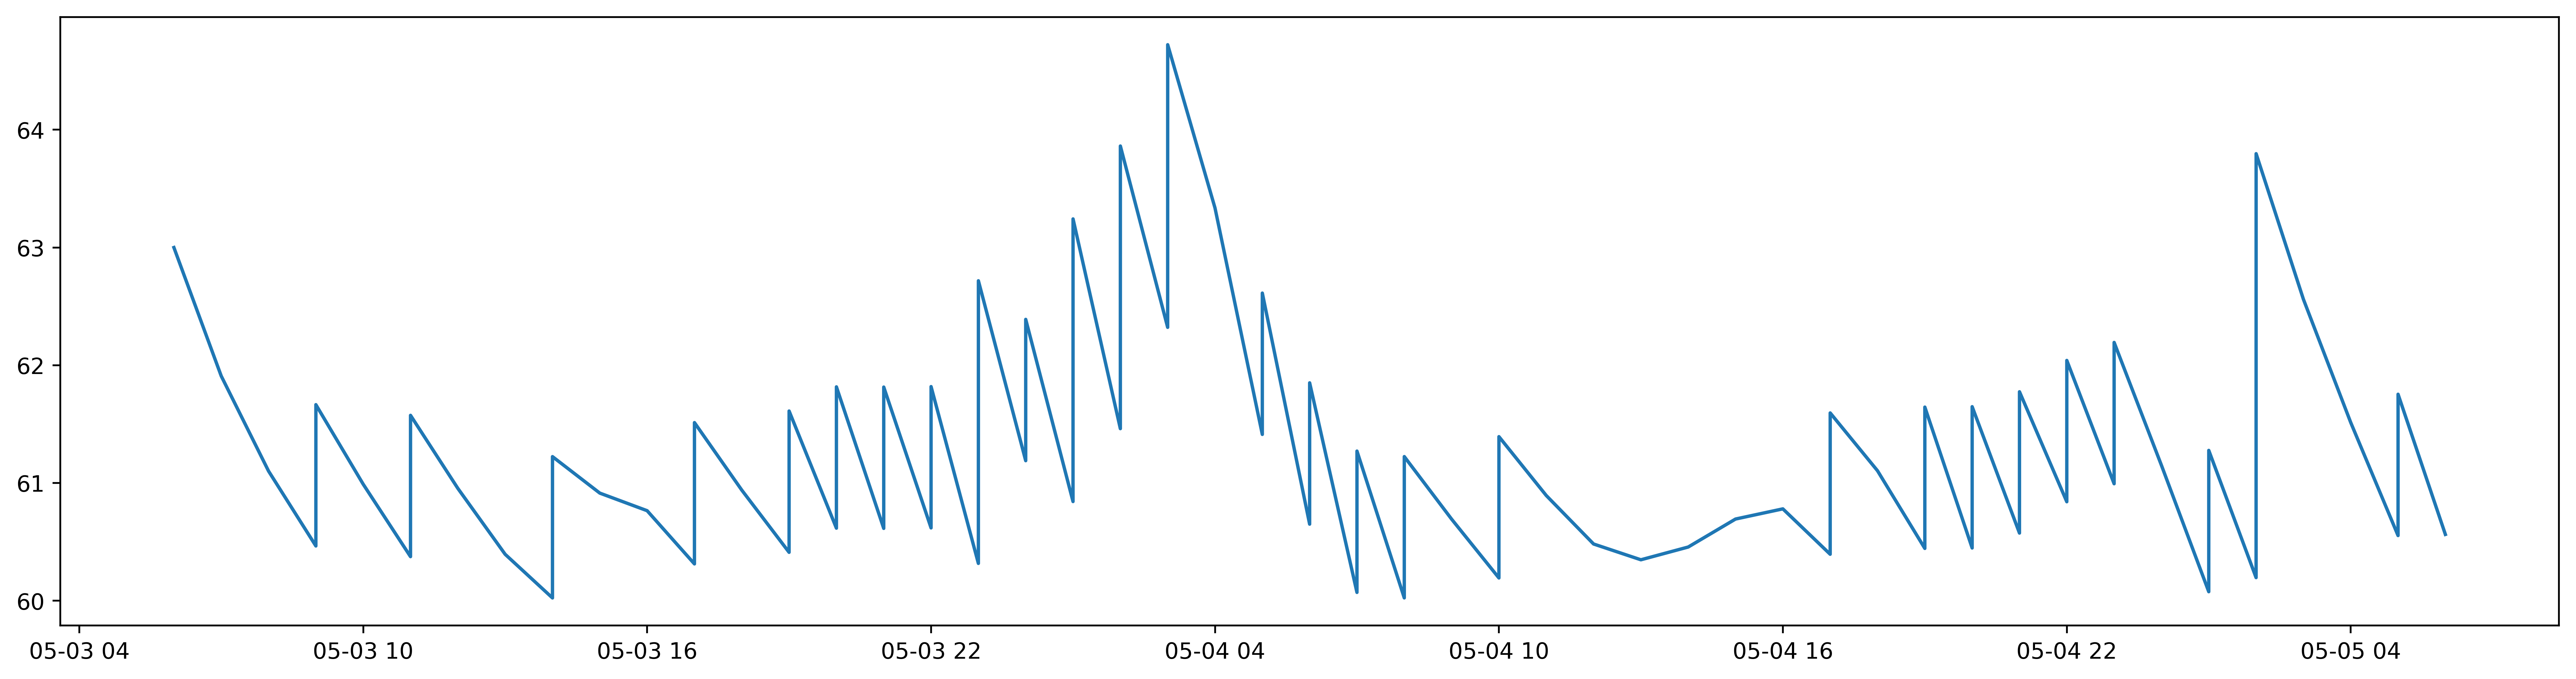

In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 5), dpi=500, facecolor='w', edgecolor='k')
temp = np.array(soilMoisturesAndTimes).transpose()
plt.plot(temp[1],temp[0])

In [24]:
import pandas as pd
soilMoistureFolowTimeByMPC = pd.DataFrame(temp.transpose(),columns=['soil moisture','datetime','amount of watering'])
soilMoistureFolowTimeByMPC.to_csv("soil_moisture_MPC.csv")

[0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 10, 10, 11, 11, 13, 13, 15, 15, 17, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 28, 29, 29, 32, 32, 32, 32, 33, 33]


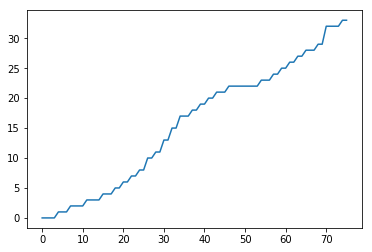

In [25]:
sumTime=[]
sumTime.append(temp[2][0])
for i in range(1,len(temp[2])):
    sumTime.append(sumTime[i-1]+temp[2][i])
print(sumTime)
plt.plot(sumTime)

### Giải thuật tưới on/off

In [ ]:
startTime = datetime.datetime(2020,5,3,11,0,0)
# soilMoisture = 65
soilMoisturesAndTimes = []
soilMoisturesAndTimes.append((soilMoisture,startTime))
def isValidThreshold(soilMoisture):
    if soilMoisture<lowerThreshold or soilMoisture>upperThreshold:
        return false
    return true
for i in range(12):
    if soilMoisture<lowerThreshold:
        soilMoisture=